In [1]:
import sys
sys.path.append("./../..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

#
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
#
from effcn.models_mnist import CapsNet, CapsNetCross,EffCapsNetCross, EffCapsNet
from misc.utils import count_parameters, calc_receptive_field, layer_conv, bb_pc_vals, calc_layer_combs, rf_layer_combs
from misc.plot_utils import imshow, plot_mat
from misc.capsule_activations import affine_shear, affine_scale, affine_rot, affine_ytrans, affine_xtrans, plt_lin, calc_pc_corr, calc_pc_norm_kld, calc_pc_delta, show_pc_vals, show_imgrid

In [4]:
from matplotlib import style

style.use('dark_background')

### Local Func

In [5]:
class TwinAugmentation(nn.Module):
    """
        double random augmentation of a input 
    """
    def __init__(self,
                crop_size=28,
                rotade=30,
                translate=[0.2,0.2],
                scale=[0.9, 1.1],
                shear=[-3,3],
                factor=1.
        ):
        
        super().__init__()
        self.transforms = T.Compose([
                                T.RandomCrop(size=crop_size),
                                T.RandomAffine(degrees=rotade*factor,
                                                translate=[translate[0]*factor,translate[1]*factor],
                                                scale=[scale[0]/factor,scale[1]*factor],
                                                shear=[shear[0]/factor,shear[1]*factor]),
                                ])
    
    def forward(self, x):
        x1 = self.transforms(x)
        x2 = self.transforms(x)
        return x1, x2

### Load Dataset

In [6]:
p_data = '/mnt/data/datasets'

In [7]:
ds = datasets.MNIST(root=p_data, train=True,download=False, transform=T.ToTensor())

In [8]:
bs = 32
shuffle=False
dl = torch.utils.data.DataLoader(ds,batch_size=bs,shuffle=shuffle)

In [9]:
x, y = next(iter(dl))

tensor([[5, 0, 4, 1, 9, 2, 1, 3],
        [1, 4, 3, 5, 3, 6, 1, 7],
        [2, 8, 6, 9, 4, 0, 9, 1],
        [1, 2, 4, 3, 2, 7, 3, 8]])


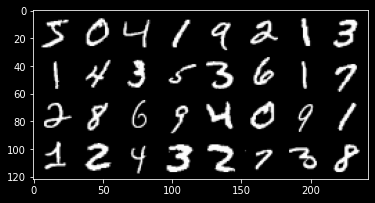

In [10]:
show_imgrid(x,y,nrow=8)

### Load Model

In [11]:
if torch.cuda.is_available():  
    dev = "cuda:0"
else:  
    dev = "cpu"  
device = torch.device(dev)

torch.cuda.current_device()

0

In [12]:
p_model = '/mnt/data/experiments/CN/mnist/mnist_CapsNet_2022_05_17_13_28_17/ckpts/model_150.ckpt'

In [13]:
model = CapsNet()
model.load_state_dict(torch.load(p_model))
model.eval()
model = model.to(device)

### signal correlation

In [16]:
model.eval()

augmentation = TwinAugmentation(factor=2)
activations1 = []
activations2 = []
    
i = 0

for x,y_true in dl:
    x = x.to(device)
    x1, x2 = augmentation(x)
        
    with torch.no_grad():
        _, _, u_l1, _ = model.forward_pc_study(x1)
        _, _, u_l2, _ = model.forward_pc_study(x2)
    
    norm1 = torch.norm(u_l1, dim=-1).tolist()
    norm2 = torch.norm(u_l2, dim=-1).tolist()
    
    activations1.extend(norm1)
    activations2.extend(norm2)

activations1 = torch.tensor(activations1)
activations2 = torch.tensor(activations2)

activations = torch.cat((activations1.unsqueeze(-1), activations2.unsqueeze(-1)),dim=-1).transpose(dim0=0, dim1=1)

act_var = activations.var(dim=-1)
caps_mean = act_var.mean(dim=-1)
caps_std = act_var.std(dim=-1)

activations.shape, act_var.mean(), act_var.std()

RuntimeError: uniform_ expects to return a [from, to) range, but found from=1.8 > to=0.55

Variace of augmentations 

factor=1

(torch.Size([1152, 96, 2]), tensor(0.0163), tensor(0.0428))
(torch.Size([1152, 60000, 2]), tensor(0.0158), tensor(0.0420))

#### augmentation

tensor([[5, 0, 4, 1, 9, 2, 1, 3],
        [1, 4, 3, 5, 3, 6, 1, 7],
        [2, 8, 6, 9, 4, 0, 9, 1],
        [1, 2, 4, 3, 2, 7, 3, 8]])


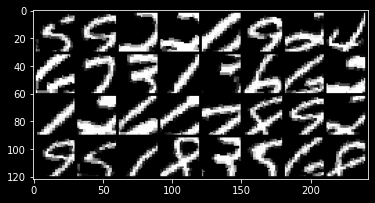

tensor([[5, 0, 4, 1, 9, 2, 1, 3],
        [1, 4, 3, 5, 3, 6, 1, 7],
        [2, 8, 6, 9, 4, 0, 9, 1],
        [1, 2, 4, 3, 2, 7, 3, 8]])


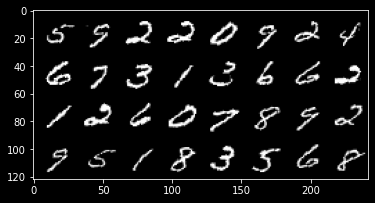

(None, None)

In [15]:
B = TwinAugmentation(factor=0.5)


x1, x2 = B(x)

show_imgrid(x1.detach().cpu(),y,nrow=8), show_imgrid(x2.detach().cpu(),y,nrow=8)